In [16]:
import numpy as np
import matplotlib.pyplot as plt
from cicTools import *
from scipy import spatial
import configparser
from astropy.io import ascii
import readgadget
import readfof
import redshift_space_library as RSL

config = configparser.ConfigParser()
config.read('config.ini')

write = config['PARAMS'].getboolean('write') #write files with results
plot = config['PARAMS'].getboolean('plot') #plot results for checking  

seed = int(config['PARAMS']['seed']) #random seed
#lbox = float(config['PARAMS']['lbox']) #length of box
ngxs = float(config['PARAMS']['ngxs']) #dilution
zspace = config['PARAMS'].getboolean('zspace') #redshift space
zspaceAxis = config['PARAMS']['zspaceAxis'] #r-space axis
nesf = int(config['PARAMS']['nesf']) #num of test spheres
rsbin = int(config['PARAMS']['rsbin']) #num of bins of r
jk = int(config['PARAMS']['jk']) #num of bins of r
invoid = config['PARAMS'].getboolean('invoid') #redshift space
#completeRrange = config['PARAMS'].getboolean('completeRrange')
snap = int(config['PARAMS']['snap']) #snapshot number
minmass = float(config['PARAMS']['minmass']) #log10 of minimum mass
maxmass = float(config['PARAMS']['maxmass']) #log10 of maximum mass 
minradV = float(config['PARAMS']['minradV']) #minimum void radius
voidfile = str(config['PARAMS']['voidfile']) #location of voids file / which voids to use
delta = str(config['PARAMS']['delta']) #delta used in void identification
voids_zs = config['PARAMS'].getboolean('voids_zs') #read voids identified in z-space
evolDelta = config['PARAMS'].getboolean('evolDelta') #read voids identified with evolved integrated delta



In [17]:

#
#-----------
# Read data from Quijote
#-----------
#
snapdir = '/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/fiducial/0/' #folder hosting the catalogue
snapnum = 4   
# get the name of the corresponding snapshot
snapshot = '/home/fdavilakurban/mnt/clemente/quijote/Snapshots/fiducial/0/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

print('BoxSize = %.3f Mpc/h'%BoxSize)
#print('Number of particles in the snapshot:',Nall)
#print('Omega_m = %.3f'%Omega_m)
#print('Omega_l = %.3f'%Omega_l)
#print('h = %.3f'%h)
print('redshift = %.1f'%redshift)

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
gxs = FoF.GroupPos/1e3  #Halo positions in Mpc/h


BoxSize = 1000.000 Mpc/h
redshift = 0.0


In [18]:
if ngxs!=0:
    #np.random.seed(seed)
    ids = np.random.choice(len(gxs),size=int(len(gxs)*ngxs))
    gxs = gxs[ids]

In [19]:
rmin, rmax = 3, 90
rs = np.geomspace(rmin,rmax,rsbin)

#
#-----------
# Replicate box edges periodically
#-----------
#
print('Replicating box:')
newgxs = perrep_array(gxs,BoxSize,np.max(rs))
print(f'Num of original gxs in box: {len(gxs)}\n\
Num of gxs after replication: {len(newgxs)}')


Replicating box:
Num of original gxs in box: 406660
Num of gxs after replication: 665625


In [20]:
#
#-----------
# Distant observer aproximation for z-space
#-----------
#
if zspace == True:
    print('Simulating zspace')
    H0 = .06774
    axis = zspaceAxis
    vaxis = 'v'+axis
    newgxs[axis]+=newgxs[vaxis]/H0
    newgxs[axis][np.where(newgxs[axis]<0.)[0]]+=BoxSize
    newgxs[axis][np.where(newgxs[axis]>BoxSize)[0]]-=BoxSize


In [21]:
#
#-----------
# VPF calculations
#-----------
#
#pos = np.column_stack((newgxs['x'],newgxs['y'],newgxs['z']))

tree = spatial.cKDTree(newgxs)

chi = np.zeros(len(rs))
NXi = np.zeros(len(rs))
P0 = np.zeros(len(rs))
N_mean = np.zeros(len(rs))
xi_mean = np.zeros(len(rs))

if invoid == False:
    if jk!= 0:
        chi_std = np.zeros(len(rs))
        NXi_std = np.zeros(len(rs))
        P0_std = np.zeros(len(rs))
        N_mean_std = np.zeros(len(rs))
        xi_mean_std = np.zeros(len(rs))

        print('Calculating JK cic statistics...')
        
        for i,r in enumerate(rs):
            chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
                    chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i]\
                        = cic_stats_jk_try(tree, nesf, r, BoxSize, jk)
    # else:
    #     print('Calculating cic statistics...')
    #     for i,r in enumerate(rs):
    #         chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
    #                     = cic_stats(tree, nesf, r, lbox)


Calculating JK cic statistics...


/tmp/ipykernel_5136/4079200093.py:27: UserWarning: Warning: converting a masked element to nan.
  chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
/tmp/ipykernel_5136/4079200093.py:28: UserWarning: Warning: converting a masked element to nan.
  chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i]\


In [22]:
print(NXi)

[ 0.20320138  0.44711418  0.9015427   1.60757711  2.70374406  4.33776805
  6.68552093  9.32428378 12.11438987 15.05720272]


In [23]:
namefile = f'../data/halos_{rmin}_{rmax}_{rsbin}.npz'

#
#-----------
# Writing file
#-----------

if write==True:
    print(f'Creating {namefile}')
    if jk!=0:
        np.savez(namefile,chi,chi_std,NXi,NXi_std,P0,P0_std,N_mean,N_mean_std,xi_mean,xi_mean_std,rs)
    else:
        np.savez(namefile,chi,NXi,P0,N_mean,xi_mean,rs)

print(chi, chi_std, rs)

Creating ../data/halos_3_90_10.npz
[0.9014389  0.81079998 0.68458132 0.55844286 0.42760059 0.32378546
        nan        nan        nan        nan] [0.00324856 0.0040084  0.00335519 0.00210637 0.0011668  0.00233457
        nan        nan        nan        nan] [ 3.          4.37769841  6.38808112  9.32169752 13.6025268  19.84925331
 28.96468154 42.26621343 61.67624509 90.        ]


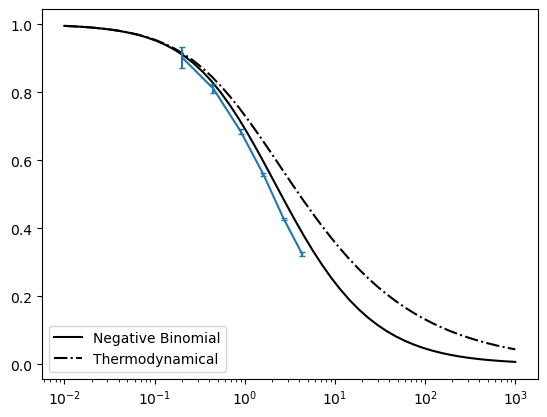

In [24]:
if plot==True:
    x = np.geomspace(1E-2,1E3,50)
    c='k'
    #chi = -np.log(P0)/N_mean
    #NE = N_mean*xi_mean

    P0err=delta_P0(P0,nesf)
    chierr=delta_chi(chi,P0,P0err,N_mean,N_mean_std)


    plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
    #a=.3
    #plt.plot(x,(1/((1-a)*(x/a)))*((1+x/a)**(1-a)-1),label='Generalized Hierarhichal',c=c,ls='--')
    #plt.plot(x,(1-np.e**(-x))/x,label='Minimal')
    plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')
    #plt.plot(x[:-15],1-x[:-15]/2,label='Gauss',c=c)
    # Q=1
    # plt.plot(x,1-(np.euler_gamma+np.log(4*Q*x))/(8*Q),label='BBGKY',c=c,ls=':')

    #plt.plot(NXi,chi,lw=2)
    plt.errorbar(NXi,chi,yerr=chierr,capsize=2)

    plt.xscale('log')
    plt.legend(loc=3)
    plt.show()
